In [1]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [3]:
num_workers = 0
batch_size = 64
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data',train=True,download=True,transform=transform)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,num_workers=num_workers)

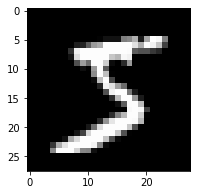

In [4]:
import numpy as np
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images,labels = dataiter.next()
images = images.numpy()

img =np.squeeze(images[0])
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(img,cmap='gray')

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self,input_size,hidden_dim,output_size):
        super(Discriminator,self).__init__()

        self.fc1 = nn.Linear(input_size,hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4,hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim * 2 ,hidden_dim)

        self.fc4 = nn.Linear(hidden_dim,output_size)
        self.dropout = nn.Dropout(0.3)

  

    def forward(self,x):
        x = x.view(-1,28*28)

        x = F.leaky_relu(self.fc1(x),negative_slope = 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x),0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x),0.2)
        x = self.dropout(x)
        out = self.fc4(x)
        return out


In [6]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator,self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2,hidden_dim*4)

        self.fc4 = nn.Linear(hidden_dim*4,output_size)
        self.dropout = nn.Dropout(0.3)
    def forward(self,x):
        x = F.leaky_relu(self.fc1(x),negative_slope = 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x),0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x),0.2)
        x = self.dropout(x)
        out = F.tanh(self.fc4(x))

        return out


In [7]:
input_size = 784

d_output_size = 1
d_hidden_size = 32

z_size =100
g_output_size = 784
g_hidden_size = 32

In [8]:
D = Discriminator(input_size,d_hidden_size,d_output_size)
G = Generator(z_size,g_hidden_size,g_output_size)

print(D)

print('********************************************************')

print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
********************************************************
Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [9]:
def real_loss(D_out,smooth=False):
    
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)


    criterion = nn.BCEWithLogitsLoss()

    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()

    loss = criterion(D_out.squeeze(),labels)
    return loss


In [10]:
import torch.optim as optim
lr =0.002
d_optimizer = optim.Adam(D.parameters(),lr)
g_optimizer = optim.Adam(G.parameters(),lr)

In [11]:
import pickle as pkl

num_epochs = 50

samples=[]
losses = []
print_every = 400

sample_size =16

fixed_z = np.random.uniform(-1,1,size=(sample_size,z_size))
fixed_z = torch.from_numpy(fixed_z).float()

D.train()
G.train()

for epoch in range(num_epochs):
    for batch_i,(real_images,_) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images*2 - 1

        d_optimizer.zero_grad()

        D_real = D(real_images)
        d_real_loss = real_loss(D_real,smooth=True)

        z = np.random.uniform(-1,1,size=(batch_size,z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        D_fake = D(fake_images)
        d_fake_loss  = fake_loss(D_fake)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        g_optimizer.zero_grad()

        z = np.random.uniform(-1,1,size=(batch_size,z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)

        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, num_epochs, d_loss.item(), g_loss.item()))
    
        losses.append((d_loss.item(),g_loss.item()))

        G.eval()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()

with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)




/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   50] | d_loss: 1.3608 | g_loss: 0.6978
Epoch [    1/   50] | d_loss: 0.8416 | g_loss: 2.6959
Epoch [    1/   50] | d_loss: 1.1395 | g_loss: 1.1202
Epoch [    2/   50] | d_loss: 1.3188 | g_loss: 1.2986
Epoch [    2/   50] | d_loss: 0.9210 | g_loss: 1.8317
Epoch [    2/   50] | d_loss: 1.2016 | g_loss: 0.8482
Epoch [    3/   50] | d_loss: 1.2907 | g_loss: 0.9142
Epoch [    3/   50] | d_loss: 1.1074 | g_loss: 1.4934
Epoch [    3/   50] | d_loss: 1.2629 | g_loss: 1.0265
Epoch [    4/   50] | d_loss: 1.2843 | g_loss: 0.7873
Epoch [    4/   50] | d_loss: 1.2885 | g_loss: 1.0345
Epoch [    4/   50] | d_loss: 1.3385 | g_loss: 0.9860
Epoch [    5/   50] | d_loss: 1.2691 | g_loss: 1.5311
Epoch [    5/   50] | d_loss: 1.2442 | g_loss: 1.3880
Epoch [    5/   50] | d_loss: 1.2522 | g_loss: 0.9193
Epoch [    6/   50] | d_loss: 1.5289 | g_loss: 1.2353
Epoch [    6/   50] | d_loss: 1.2220 | g_loss: 1.0104
Epoch [    6/   50] | d_loss: 1.0389 | g_loss: 1.2888
Epoch [    7/   50] | d_loss

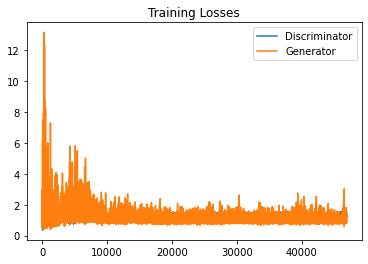

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [13]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [14]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

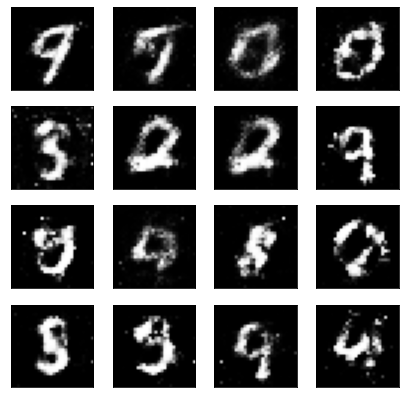

In [15]:
view_samples(-1, samples)

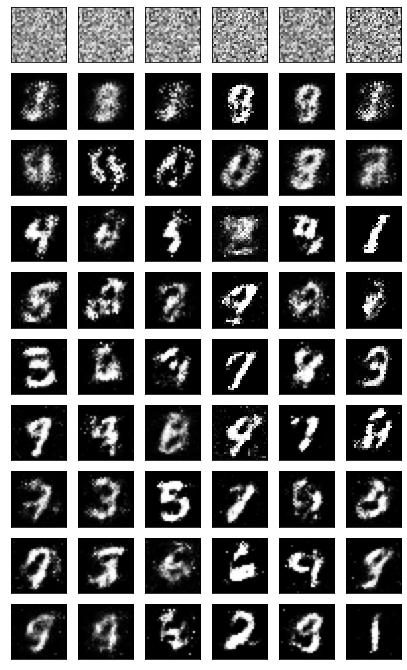

In [16]:
rows = 10 
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


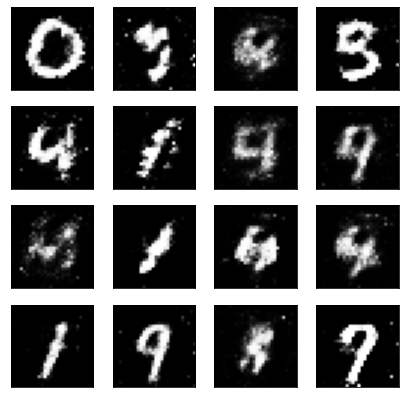

In [17]:


# randomly generated, new latent vectors using the noise
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

